In [1]:
!pip install pycryptodome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.4 MB/s eta 0:00:00


In [2]:
from scipy.io import wavfile 
import numpy as np
import matplotlib.pyplot as plt
import random
import string
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad,unpad
import time

# SENDER CODE:

<ipython-input-105-967dcfc44894>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs,data = wavfile.read('/content/audio.wav')


Text(0.5, 1.0, 'Original audio plot')

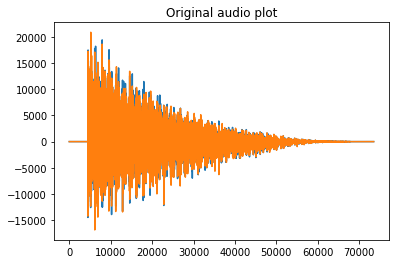

In [105]:
fs,data = wavfile.read('/content/audio.wav')
plt.plot(data)
plt.title("Original audio plot")

In [106]:
data

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int16)

In [107]:
with open('/content/audio.wav', 'rb') as fd:
    contents = fd.read()

In [108]:
AES_KEY = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for x in range(32))

AES_IV = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for x in range(16))

In [109]:
print("AES Key is ", AES_KEY)
print("AES Initialization vector is ", AES_IV)

AES Key is  u7b0ZMchR8B0h1D1wQ4z6O1tpobHzFKj
AES Initialization vector is  r94bztbP2bVWsio2


In [110]:
encryptor = AES.new(AES_KEY.encode("utf-8"), AES.MODE_CFB, AES_IV.encode("utf-8"))

In [111]:
from Crypto.Util.Padding import pad
encrypted_audio_pad=pad(contents,AES.block_size)

In [112]:
encrypted_audio=encryptor.encrypt(encrypted_audio_pad)

In [114]:
encrypted_audio[:10]

b'\xdf\xeb`=>\xda\x8e\x98\xc0 '

In [141]:
len(encrypted_audio)

294736

# ATTACKER SIDE:

In [115]:
#decrypt the encrypted file and add noise to it
decryptor = AES.new(AES_KEY.encode("utf-8"), AES.MODE_CFB, AES_IV.encode("utf-8"))
decrypted_audio = decryptor.decrypt(encrypted_audio)

In [116]:
#remove the padding
decrypted_audio=unpad(decrypted_audio,AES.block_size)

In [140]:
len(decrypted_audio)

294730

In [117]:
print(decrypted_audio[:10])

b'RIFFB\x7f\x04\x00WA'


In [118]:
with open("decrypt.wav","wb") as f:
  f.write(decrypted_audio)

In [119]:
fs,data=wavfile.read("decrypt.wav")

<ipython-input-119-782d9d911bef>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs,data=wavfile.read("decrypt.wav")


In [120]:
data

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int16)

In [121]:
data.shape

(73500, 2)

In [122]:
sample=np.random.randn(len(data)*2).reshape(data.shape)

In [123]:
sample.shape

(73500, 2)

In [124]:
noise=data+sample

In [126]:
noise-sample #removing noise

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

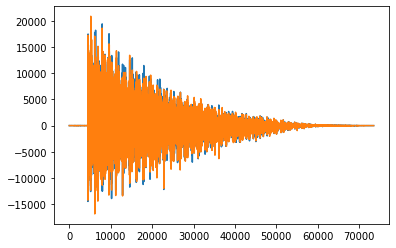

In [127]:
plt.plot(noise)

In [128]:
noise[:5]

array([[ 0.99538241,  0.65798134],
       [ 0.38182636,  0.73604026],
       [-0.07632632,  1.52607595],
       [ 1.04099888,  0.33555592],
       [-1.46366058, -2.3627227 ]])

In [35]:
#AES_KEY = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for x in range(32))

#AES_IV = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for x in range(16))

In [ ]:
#(AES_IV,AES_KEY)

In [129]:
encryptor = AES.new(AES_KEY.encode("utf-8"), AES.MODE_CFB, AES_IV.encode("utf-8"))

In [130]:
#encrypt the noise data and send to the reciver
encrypted_noise_audio=encryptor.encrypt(bytes(noise))

In [131]:
encrypted_noise_audio[:5]

b'uN\x93zC'

In [214]:
len(encrypted_noise_audio)

1176000

# Reciever side

In [213]:
# decrypt the noisy ciphertext
cipher = AES.new(AES_KEY.encode("utf-8"), AES.MODE_CFB, AES_IV.encode("utf-8"))
plaintext = cipher.decrypt(encrypted_noise_audio)

In [133]:
bytes(noise)[:10]

b'\xf8I07,\xda\xef?l\xda'

In [134]:
plaintext[:10]

b'\xf8I07,\xda\xef?l\xda'

In [215]:
true_data=np.frombuffer(plaintext,dtype=np.float64)

In [216]:
len(true_data)

147000

In [198]:
len(true_data)//2

73500

In [217]:
np.finfo(dtype=np.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [221]:
true_data=true_data.reshape((len(true_data)//2,2))

In [218]:
np.where(true_data<np.finfo(dtype=np.float64).min)

(array([], dtype=int64),)

In [208]:
true_data=np.delete(true_data,np.where(true_data<np.finfo(dtype=np.float64).min))

In [209]:
np.where(true_data<np.finfo(dtype=np.float64).min)

(array([], dtype=int64),)

In [180]:
true_data=true_data[~np.isnan(true_data)]

In [219]:
print(true_data)

[ 0.99538241  0.65798134  0.38182636 ... -0.21067515 -2.31070506
 -0.15831008]


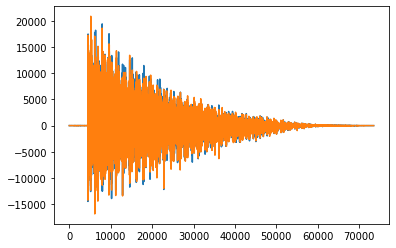

In [222]:
plt.plot(true_data)

In [143]:
with open("recived.wav","wb") as f:
  f.write(bytearray(true_data))

In [44]:
#import librosa

In [45]:
#y,_=librosa.load("audio.wav",sr=16000)

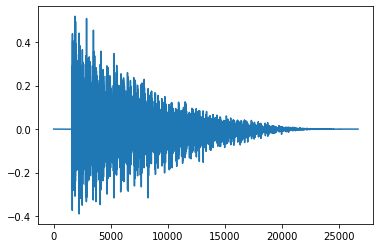

In [46]:
#plt.plot(y)

In [47]:
#x,_=librosa.load("input_bytes.wav",sr=16000)

/usr/local/lib/python3.8/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [53]:
#noise-sample

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
#!python3 -m pip install kaitaistruct

In [ ]:
#from kaitaistruct import KaitaiStream, BytesIO
#data = KaitaiStream(BytesIO(plaintext))